# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.265501,True,5.393182
1,0.094058,True,5.558055
2,1.723442,True,7.818396
3,0.738826,True,4.918844
4,1.732605,True,6.192352
...,...,...,...
995,-1.734299,False,-2.646016
996,-0.049728,False,-0.055587
997,1.629305,True,7.846121
998,-0.137889,True,5.907617


<Axes: xlabel='v0'>

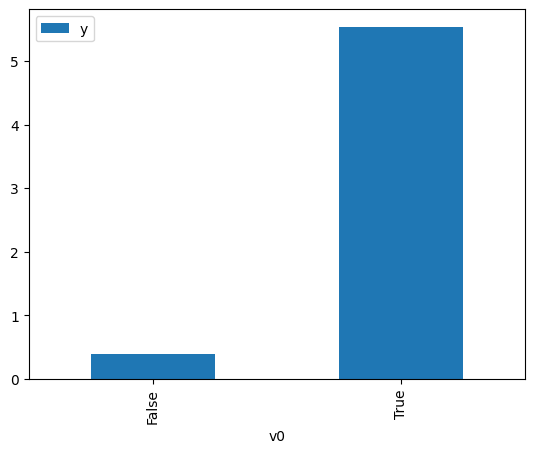

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

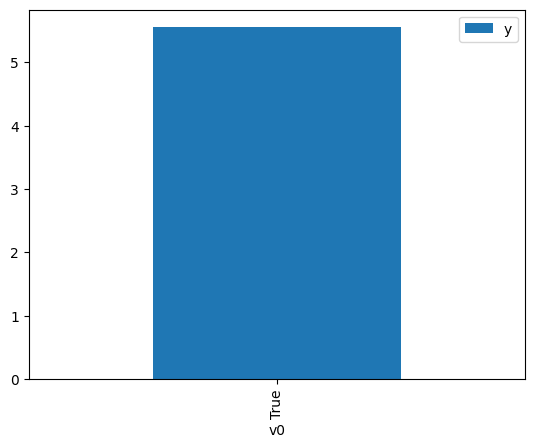

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.998775,False,0.329228,0.173878,5.751156
1,1.042165,False,2.559233,0.164859,6.065808
2,0.623538,False,2.209779,0.268191,3.728680
3,0.884791,False,0.775999,0.199419,5.014563
4,1.375710,False,1.927038,0.107603,9.293448
...,...,...,...,...,...
995,-0.270583,False,-1.095981,0.578744,1.727880
996,0.843951,False,2.739609,0.209230,4.779419
997,-0.941611,False,-1.234182,0.787403,1.269997
998,1.198790,False,0.966740,0.135405,7.385261


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.256182,True,5.477226,0.426454,2.344921
1,0.765586,True,6.780189,0.770962,1.297080
2,2.686171,True,7.511626,0.982913,1.017384
3,-1.080264,True,4.966821,0.180308,5.546059
4,-1.198305,True,3.037092,0.155945,6.412528
...,...,...,...,...,...
995,-0.266668,True,4.557730,0.422667,2.365927
996,1.786251,True,9.065879,0.938325,1.065729
997,1.250483,True,8.303457,0.873293,1.145091
998,-0.439681,True,6.042712,0.361806,2.763909


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.955
Model:                            OLS   Adj. R-squared (uncentered):              0.955
Method:                 Least Squares   F-statistic:                          1.063e+04
Date:                Tue, 21 Nov 2023   Prob (F-statistic):                        0.00
Time:                        18:03:04   Log-Likelihood:                         -1443.8
No. Observations:                1000   AIC:                                      2892.
Df Residuals:                     998   BIC:                                      2901.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.3506      0.037     36.072      0.000       1.277       1.424
x2             4.9243      0.050     97.975      0.000       4.826       5.023
==============================================================================
Omnibus:                        0.387   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.824   Jarque-Bera (JB):                0.474
Skew:                           0.026   Prob(JB):                        0.789
Kurtosis:                       2.906   Cond. No.                         2.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""